<a href="https://colab.research.google.com/github/pranjal299/cv-project/blob/main/Weight_Estimation_MultiInput_SimpleCNN_Cropped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure you have this folder as shortcut in your drive - /content/gdrive/MyDrive/Morota-video-data/ 

In [3]:
#Mount Google Drive 
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


### Data Loading

In [4]:
#@markdown Select resolution of input dataset and weeks of data

Instantiate_New_Dataset = True #@param {type:"boolean"}
Refresh_Old_Dataset = False #@param {type:"boolean"}

if Instantiate_New_Dataset == True:
  !rm -rf Week*/

Resolution = "256"  #@param ['720', '512', '256']

if Refresh_Old_Dataset == False:
  if Resolution == "720":
    !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_720.zip .
    !unzip -qq CROPPED_WEEK1-10_720.zip -d .
    !rm -rf *WEEK*.zip

  if Resolution == "512":
    !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_512.zip .
    !unzip -qq CROPPED_WEEK1-10_512.zip -d .
    !rm -rf *WEEK*.zip

  if Resolution == "256":
    !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_256.zip .
    !unzip -qq CROPPED_WEEK1-10_256.zip -d .
    !rm -rf *WEEK*.zip

### Mapping Table Input

In [5]:
import pandas as pd

In [6]:
final_map = pd.read_csv("/content/gdrive/MyDrive/Morota-video-data/final_mapping.csv")

In [7]:
weeks = final_map

In [8]:
weeks

,image_path,Date,Pig,weight,Week
0,Week1/20210922/20210922_3330_b/_Depth_4683.jpg,20210922,3330,15.5,1
1,Week1/20210922/20210922_3330_b/_Depth_4778.jpg,20210922,3330,15.5,1
2,Week1/20210922/20210922_3330_b/_Depth_4579.jpg,20210922,3330,15.5,1
3,Week1/20210922/20210922_3330_b/_Depth_4578.jpg,20210922,3330,15.5,1
4,Week1/20210922/20210922_3330_b/_Depth_4584.jpg,20210922,3330,15.5,1
...,...,...,...,...,...
96220,Week10/20211119/20211119_3342/_Depth_3504.jpg,20211119,3342,56.6,10
96221,Week10/20211119/20211119_3342/_Depth_3318.jpg,20211119,3342,56.6,10
96222,Week10/20211119/20211119_3342/_Depth_3476.jpg,20211119,3342,56.6,10
96223,Week10/20211119/20211119_3342/_Depth_3169.jpg,20211119,3342,56.6,10


In [24]:
weeks_train = weeks[weeks["Pig"] != 3330]
#weeks_test = weeks[weeks['image_path'].str.contains('Week1/|Week2/')]

In [25]:
weeks_test = weeks[weeks["Pig"] == 3330]
#weeks_train = weeks[~weeks['image_path'].str.contains('Week1/|Week2/')]

In [26]:
image_paths_train = weeks_train['image_path'].values
labels_train = weeks_train['weight'].values
image_paths_test = weeks_test['image_path'].values
labels_test = weeks_test['weight'].values

### Dataset

In [27]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((image_paths_train, labels_train))
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths_test, labels_test))

In [29]:
IMG_SIZE = int(Resolution)
channels = 1

def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0

    edge_map = tf.numpy_function(canny_edge_detection, [img], tf.float32)
    edge_map.set_shape((IMG_SIZE, IMG_SIZE, 1))

    return (img, edge_map), label

def canny_edge_detection(image, low_threshold=100, high_threshold=200):
    image = image.squeeze() * 255
    image = image.astype(np.uint8)
    edge_map = cv2.Canny(image, low_threshold, high_threshold)
    edge_map = edge_map.astype(np.float32) / 255.0
    edge_map = np.expand_dims(edge_map, axis=-1)
    return edge_map

In [30]:
print("Number of elements in the train dataset:", tf.data.experimental.cardinality(train_dataset).numpy())
print("Number of elements in the test dataset:", tf.data.experimental.cardinality(test_dataset).numpy())

Number of elements in the train dataset: 69568
Number of elements in the test dataset: 26657


In [31]:
batch_size = 128

train_dataset = train_dataset.shuffle(len(labels_train))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

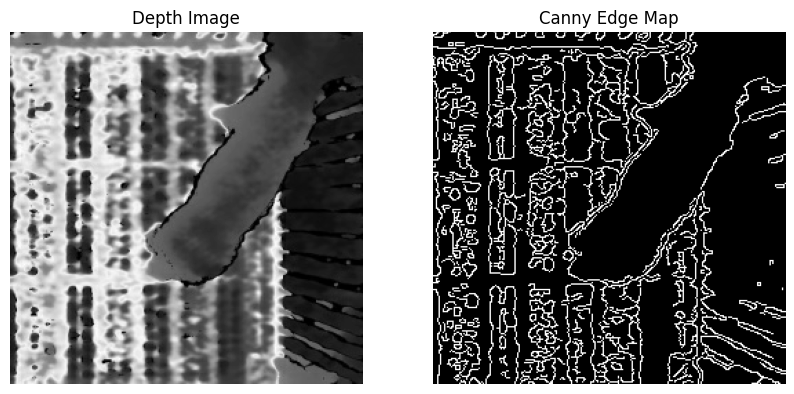

In [32]:
def visualize_sample(dataset):
    for (img_batch, edge_map_batch), label_batch in dataset.take(1):
        img = img_batch[0].numpy().squeeze()
        edge_map = edge_map_batch[0].numpy().squeeze()

        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Depth Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(edge_map, cmap='gray')
        plt.title('Canny Edge Map')
        plt.axis('off')

        plt.show()

visualize_sample(train_dataset)


### Model Config and Training

In [33]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

def create_multi_input_cnn():
    depth_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="depth_input")
    edge_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="edge_input")

    depth_conv1 = Conv2D(32, (3, 3), activation="relu")(depth_input)
    depth_pool1 = MaxPooling2D((2, 2))(depth_conv1)
    depth_conv2 = Conv2D(64, (3, 3), activation="relu")(depth_pool1)
    depth_pool2 = MaxPooling2D((2, 2))(depth_conv2)

    edge_conv1 = Conv2D(32, (3, 3), activation="relu")(edge_input)
    edge_pool1 = MaxPooling2D((2, 2))(edge_conv1)
    edge_conv2 = Conv2D(64, (3, 3), activation="relu")(edge_pool1)
    edge_pool2 = MaxPooling2D((2, 2))(edge_conv2)

    concat = Concatenate()([depth_pool2, edge_pool2])
    flat = Flatten()(concat)
    dense1 = Dense(64, activation="relu")(flat)
    output = Dense(1)(dense1)

    model = Model(inputs=[depth_input, edge_input], outputs=output)

    return model

In [34]:
model = create_multi_input_cnn()

In [35]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 depth_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 edge_input (InputLayer)        [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 254, 254, 32  320         ['depth_input[0][0]']            
                                )                                                           

In [ ]:
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
 13/544 [..............................] - ETA: 4:16 - loss: 1919.9065 - mae: 35.4473 - mape: 123.4598

In [ ]:
test_loss, test_mae, test_mape = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test mean absolute error:', test_mae)
print('Test mean absolute percentage error:', test_mape)

144/144 [==============================] - 44s 303ms/step - loss: 36.2253 - mae: 4.7119 - mape: 18.8093
Test loss: 36.22525405883789
Test mean absolute error: 4.711947441101074
Test mean absolute percentage error: 18.809282302856445
